In [1]:
import numpy as np
import torch
from gpsr.modeling import GPSRQuadScanLattice
from gpsr.datasets import split_dataset
from gpsr.ensemble import (
    train_ensemble,
    plot_2d_distribution,
    compute_mean_and_confidence_interval,
)

from gpsr.datasets import QuadScanDataset

torch.Size([20, 1]) torch.Size([20, 100, 100]) Screen(resolution=(100, 100), pixel_size=tensor([0.0010, 0.0010]), binning=1, misalignment=tensor([0., 0.]), method='kde', kde_bandwidth=tensor(0.0005), is_active=True, name='unnamed_element_0')


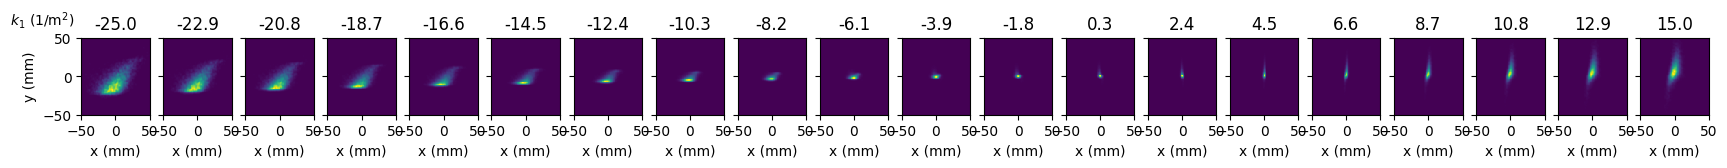

In [2]:
# load dataset
dset = torch.load(
    "example_data/example_datasets/reconstruction_4D.dset", weights_only=False
)
print(
    dset.parameters.shape,
    dset.observations[0].shape,
    dset.screen,
)
dset.plot_data();

In [3]:
# split dataset into training and test sets
train_k_ids = np.arange(0, len(dset.parameters), 2)
train_dset, test_dset = split_dataset(dset, train_k_ids)

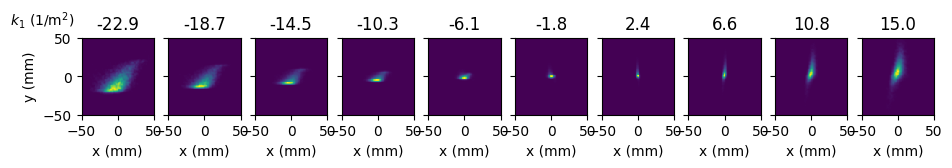

In [4]:
test_dset.plot_data();

In [5]:
# create diagnostic lattice
p0c = 43.36e6  # reference momentum in eV/c
gpsr_lattice = GPSRQuadScanLattice(
    l_quad=0.1, l_drift=1.0, screen=train_dset.screen
)

In [6]:
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=20)

result = train_ensemble(
    gpsr_lattice, train_loader, n_models=10, n_epochs=500, checkpoint_period_epochs=100
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type | Params | Mode 
--------------------------------------------
0 | gpsr_model | GPSR | 1.1 K  | train
--------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Training model 1/10...


/opt/homebrew/Caskroom/miniforge/base/envs/csr-psr/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.
/opt/homebrew/Caskroom/miniforge/base/envs/csr-psr/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 24.90it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 18.76it/s, v_num=0]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training model 2/10...



  | Name       | Type | Params | Mode 
--------------------------------------------
0 | gpsr_model | GPSR | 1.1 K  | train
--------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 24.67it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 18.65it/s, v_num=0]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type | Params | Mode 
--------------------------------------------
0 | gpsr_model | GPSR | 1.1 K  | train
--------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Training model 3/10...
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 25.29it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 19.00it/s, v_num=0]
Training model 4/10...


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type | Params | Mode 
--------------------------------------------
0 | gpsr_model | GPSR | 1.1 K  | train
--------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 25.34it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 17.00it/s, v_num=0]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type | Params | Mode 
--------------------------------------------
0 | gpsr_model | GPSR | 1.1 K  | train
--------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Training model 5/10...
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 25.53it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 19.35it/s, v_num=0]
Training model 6/10...


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type | Params | Mode 
--------------------------------------------
0 | gpsr_model | GPSR | 1.1 K  | train
--------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 25.65it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 19.50it/s, v_num=0]
Training model 7/10...


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type | Params | Mode 
--------------------------------------------
0 | gpsr_model | GPSR | 1.1 K  | train
--------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 25.86it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 19.53it/s, v_num=0]
Training model 8/10...


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type | Params | Mode 
--------------------------------------------
0 | gpsr_model | GPSR | 1.1 K  | train
--------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 25.33it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 19.14it/s, v_num=0]
Training model 9/10...


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type | Params | Mode 
--------------------------------------------
0 | gpsr_model | GPSR | 1.1 K  | train
--------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 24.50it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 18.79it/s, v_num=0]
Training model 10/10...


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type | Params | Mode 
--------------------------------------------
0 | gpsr_model | GPSR | 1.1 K  | train
--------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 25.46it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 19.32it/s, v_num=0]


In [7]:
reconstructed_beams = [ele.beam_generator() for ele in result]

/Users/jp/repos/gpsr/gpsr/ensemble.py:147: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  torch.tensor(histograms),


(<Figure size 640x480 with 4 Axes>,
 array([<Axes: title={'center': 'Mean Histogram'}, xlabel='x', ylabel='py'>,
        <Axes: >], dtype=object))

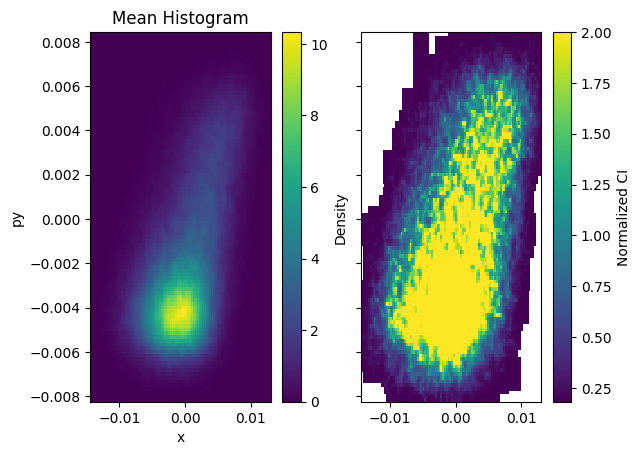

In [8]:
plot_2d_distribution(
    reconstructed_beams, "x", "py", smoothing_factor=1, ci_kws={"vmax": 2}
)

## Evaluate model on test samples to compare predictions

In [10]:
test_dset = torch.load(
    "example_data/example_datasets/reconstruction_4D_test.dset", weights_only=False
)
test_pred = torch.stack([ele(test_dset.parameters)[0].detach() for ele in result])

mean, nci = compute_mean_and_confidence_interval(test_pred.cpu())

mean_dset = QuadScanDataset(test_dset.parameters, mean, train_dset.screen)
nci_dset = QuadScanDataset(test_dset.parameters, nci, train_dset.screen)

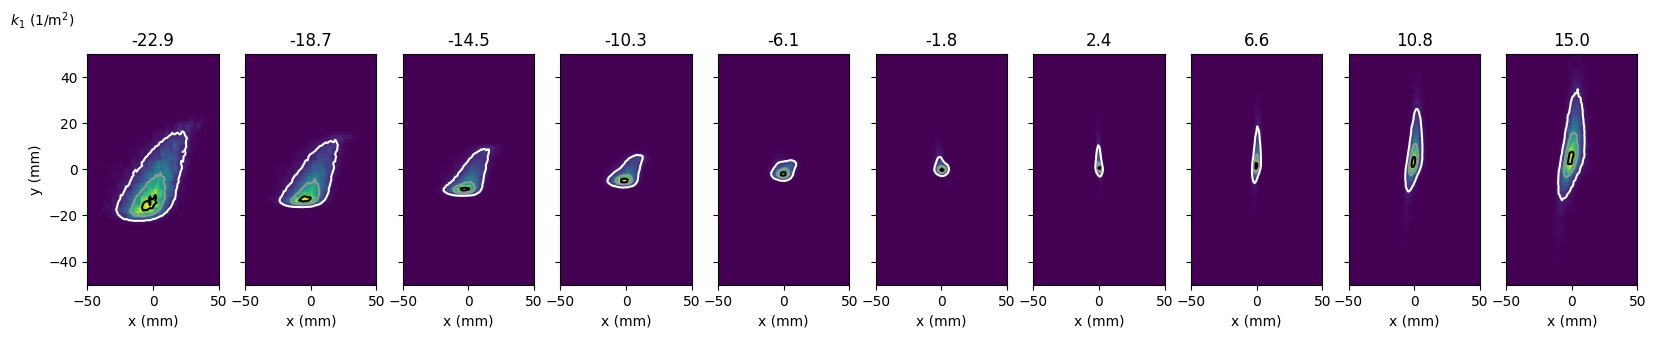

In [11]:
fig, ax = test_dset.plot_data(overlay_data=mean_dset)
fig.set_size_inches(20, 3)

### visualize normalized confidence interval

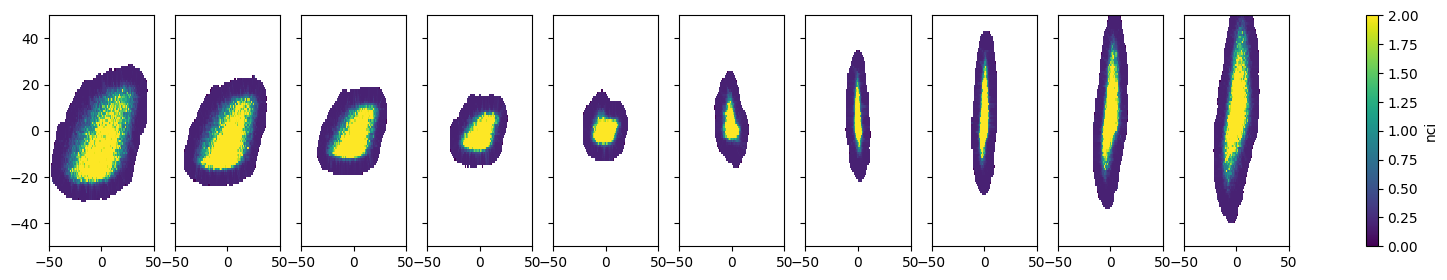

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(
    1, len(test_dset.parameters), figsize=(20, 3), sharex=True, sharey=True
)

xbins, ybins = nci_dset.screen.pixel_bin_centers
xx = torch.meshgrid(xbins * 1e3, ybins * 1e3, indexing="ij")

for i in range(len(test_dset.parameters)):
    c = ax[i].pcolormesh(*xx, nci_dset.observations[0][i], vmin=0, vmax=2)
fig.colorbar(c, ax=ax, label="nci")